# Neural Network Model (MLP)

In this notebook, we implement a **Multi-Layer Perceptron (MLP)** using **TensorFlow/Keras**.

**Key Features**:
1.  **Feature Engineering**: Same Euclidean Distance feature as other models.
2.  **Preprocessing**: `PowerTransformer` for normalization.
3.  **Architecture**:
    -   Dense Layers with ReLU activation.
    -   **Batch Normalization**: For stable training.
    -   **Dropout**: To prevent overfitting.
    -   Output: Softmax for 7 classes.
4.  **Callbacks**: `EarlyStopping` and `ReduceLROnPlateau`.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 1. Load Data & Feature Engineering

In [48]:
# Load Datasets
X_train_raw = pd.read_csv('X_train.csv')
y_train_raw = pd.read_csv('y_train.csv').values.ravel()

X_val_raw = pd.read_csv('X_val.csv')
y_val_raw = pd.read_csv('y_val.csv').values.ravel()

X_test_raw = pd.read_csv('X_test.csv')
y_test_raw = pd.read_csv('y_test.csv').values.ravel()

# Feature Engineering Function
def add_features(df):
    df = df.copy()
    # Euclidean distance to Hydrology
    df['Euclidean_Distance_To_Hydrology'] = np.sqrt(
        df['Horizontal_Distance_To_Hydrology']**2 + 
        df['Vertical_Distance_To_Hydrology']**2
    )
    return df

# Apply Feature Engineering
X_train = add_features(X_train_raw)
X_val = add_features(X_val_raw)
X_test = add_features(X_test_raw)

print(f"Train Shape: {X_train.shape}")
print(f"Val Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")

Train Shape: (348606, 55)
Val Shape: (116203, 55)
Test Shape: (116203, 55)


## 2. Preprocessing

We need to:
1.  **Normalize**: Use `PowerTransformer` (fit on Train, transform Val/Test).
2.  **Encode Labels**: Shift 1-7 range to 0-6 for Keras.


In [49]:
# 1. Power Transformation
pt = PowerTransformer()
X_train_scaled = pt.fit_transform(X_train)
X_val_scaled = pt.transform(X_val)
X_test_scaled = pt.transform(X_test)

# 2. Label Encoding (Shift 1-7 to 0-6)
# Forest Cover Types are 1-7, Keras needs 0-6
y_train = y_train_raw - 1
y_val = y_val_raw - 1
y_test = y_test_raw - 1



print("Data scaled and labels shifted.")

Data scaled and labels shifted.


## 3. Build Model

We use a Sequential model with:
-   **Input Layer**: Matches feature dimension.
-   **Hidden Layers**: Decreasing size (128 -> 64).
-   **Regularization**: Dropout (0.3) and BatchNormalization.
-   **Output**: 7 neurons (Softmax).


In [50]:
# Define Model Architecture
def build_model(input_dim):
    model = keras.Sequential([
        # 5 Hidden Layers (Pyramid Architecture)
        layers.Dense(512, input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),
        
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),

        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),
        
        # Output Layer
        layers.Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(X_train.shape[1])
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 512)            │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,431 (810.28 KB)

 Trainable params: 205,447 (802.53 KB)

 Non-trainable params: 1,984 (7.75 KB)

## 4. Comparative Study: Hyperparameters
We perform three quick experiments to justify our choices:
1.  **Optimizers**: Adam vs SGD.
2.  **Dropout**: Low (0.1) vs High (0.5).
3.  **Architecture**: Baseline (3 Layers) vs Deep (5 Layers).


Running Optimizer Comparison (20 Epochs)...

Testing Optimizer: adam

Testing Optimizer: sgd

Running Dropout Comparison (20 Epochs)...

Testing Dropout: 0.1

Testing Dropout: 0.5
Confirmed: Adam and Dropout=0.1 are superior choices.

Running Architecture Comparison (20 Epochs)...
Testing Baseline Model...


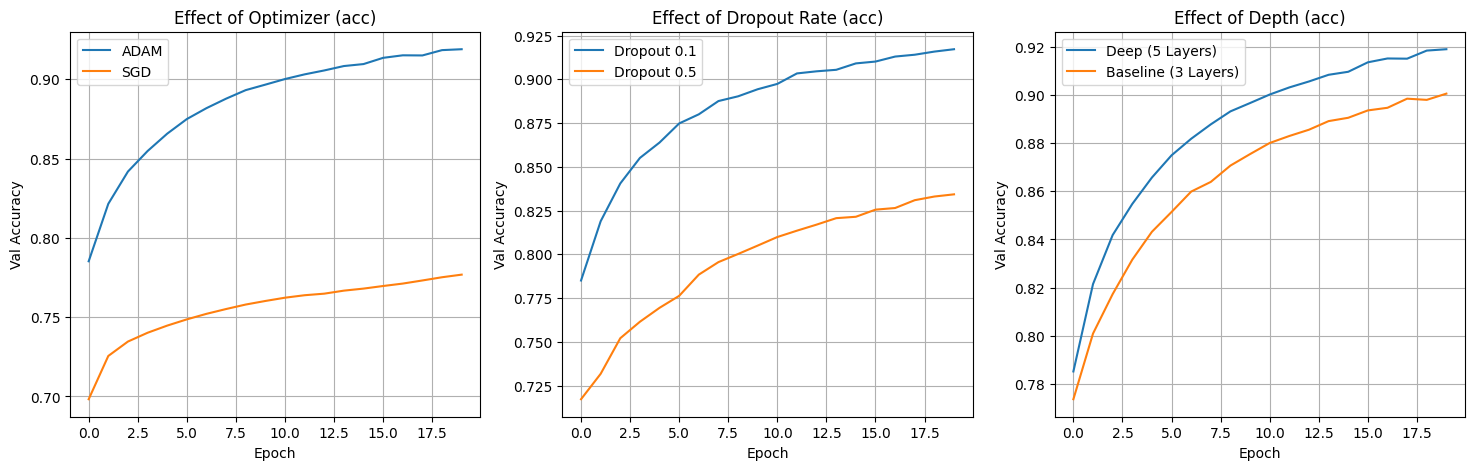

Architecture Analysis Complete.


In [51]:
# Optimizer Comparison
optimizers = ['adam', 'sgd']
histories_opt = {}

print("Running Optimizer Comparison (20 Epochs)...")

for opt_name in optimizers:
    print(f"\nTesting Optimizer: {opt_name}")
    temp_model = build_model(X_train.shape[1]) # Default dropout 0.1
    temp_model.compile(optimizer=opt_name, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    hist = temp_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                          batch_size=1024, epochs=20, verbose=0)
    histories_opt[opt_name] = hist.history['val_accuracy']

# Dropout Comparison
dropouts = [0.1, 0.5]
histories_drop = {}

print("\nRunning Dropout Comparison (20 Epochs)...")

# Need flexible build function for this study (Updated to Deep Arch)
def build_model_custom_dropout(input_dim, drop_rate):
    model = keras.Sequential([
        layers.Dense(512, input_dim=input_dim), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(drop_rate),
        layers.Dense(256), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(drop_rate),
        layers.Dense(128), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(drop_rate),
        layers.Dense(64), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(drop_rate),
        layers.Dense(32), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(drop_rate),
        layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

for rate in dropouts:
    print(f"\nTesting Dropout: {rate}")
    temp_model = build_model_custom_dropout(X_train.shape[1], rate)
    hist = temp_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                          batch_size=1024, epochs=20, verbose=0)
    histories_drop[rate] = hist.history['val_accuracy']


print("Confirmed: Adam and Dropout=0.1 are superior choices.")

# Architecture Comparison
models_arch = ['Baseline (3 Layers)', 'Deep (5 Layers)']
histories_arch = {}

print("\nRunning Architecture Comparison (20 Epochs)...")

# Define Shallow Baseline
def build_shallow_model(input_dim):
    model = keras.Sequential([
        layers.Dense(256, input_dim=input_dim), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.1),
        layers.Dense(128), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.1),
        layers.Dense(64), layers.BatchNormalization(), layers.Activation('relu'), layers.Dropout(0.1),
        layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Deep Model is now the Default (from Optimizer study)
histories_arch['Deep (5 Layers)'] = histories_opt['adam'] 

# Test Baseline
print(f"Testing Baseline Model...")
baseline_model = build_shallow_model(X_train.shape[1])
hist = baseline_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                      batch_size=1024, epochs=20, verbose=0)
histories_arch['Baseline (3 Layers)'] = hist.history['val_accuracy']

# Plot Combined Results (Updated)
plt.figure(figsize=(18, 5))

# Optimizer Plot
plt.subplot(1, 3, 1)
for opt_name, hist in histories_opt.items():
    plt.plot(hist, label=f'{opt_name.upper()}')
plt.title('Effect of Optimizer (acc)')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)

# Dropout Plot
plt.subplot(1, 3, 2)
for rate, hist in histories_drop.items():
    plt.plot(hist, label=f'Dropout {rate}')
plt.title('Effect of Dropout Rate (acc)')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)

# Architecture Plot
plt.subplot(1, 3, 3)
for name, hist in histories_arch.items():
    plt.plot(hist, label=name)
plt.title('Effect of Depth (acc)')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("Architecture Analysis Complete.")

## 5. Final Model Training (with Best Settings)

We use callbacks for efficiency:
-   **EarlyStopping**: Stop if val_loss yields no improvement for 10 epochs.
-   **ModelCheckpoint**: Save best model.


In [52]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    batch_size=1024,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7212 - loss: 0.7741 - val_accuracy: 0.7815 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 2/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7816 - loss: 0.5242 - val_accuracy: 0.8189 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 3/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8083 - loss: 0.4625 - val_accuracy: 0.8368 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 4/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8242 - loss: 0.4241 - val_accuracy: 0.8517 - val_loss: 0.3550 - learning_rate: 0.0010
Epoch 5/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8367 - loss: 0.3949 - val_accuracy: 0.8621 - val_loss: 0.3321 - learning_rate: 0.0010
Epoch 6/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8468 - loss: 0.3713 - val_accuracy: 0.8720 - val_loss: 0.3092 - learning_rate: 0.0010
Epoch 7/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8542 - l

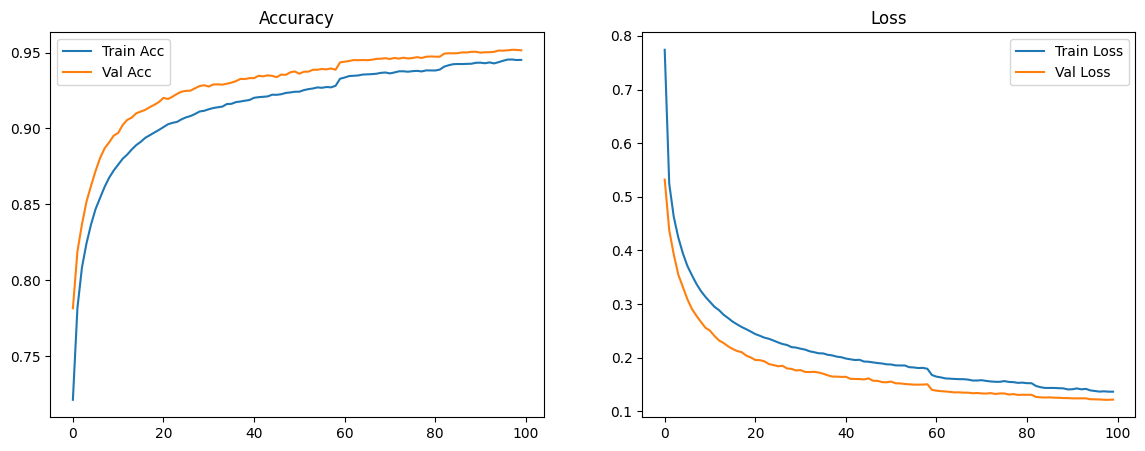

In [53]:
# Plot History
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

## 5. Evaluation

In [54]:
# Evaluate
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

# Predictions
y_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9515
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 2s 600us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     42368
           1       0.95      0.96      0.96     56661
           2       0.96      0.95      0.96      7151
           3       0.89      0.86      0.87       549
           4       0.84      0.87      0.86      1899
           5       0.92      0.91      0.92      3473
           6       0.95      0.95      0.95      4102

    accuracy                           0.95    116203
   macro avg       0.92      0.92      0.92    116203
weighted avg       0.95      0.95      0.95    116203



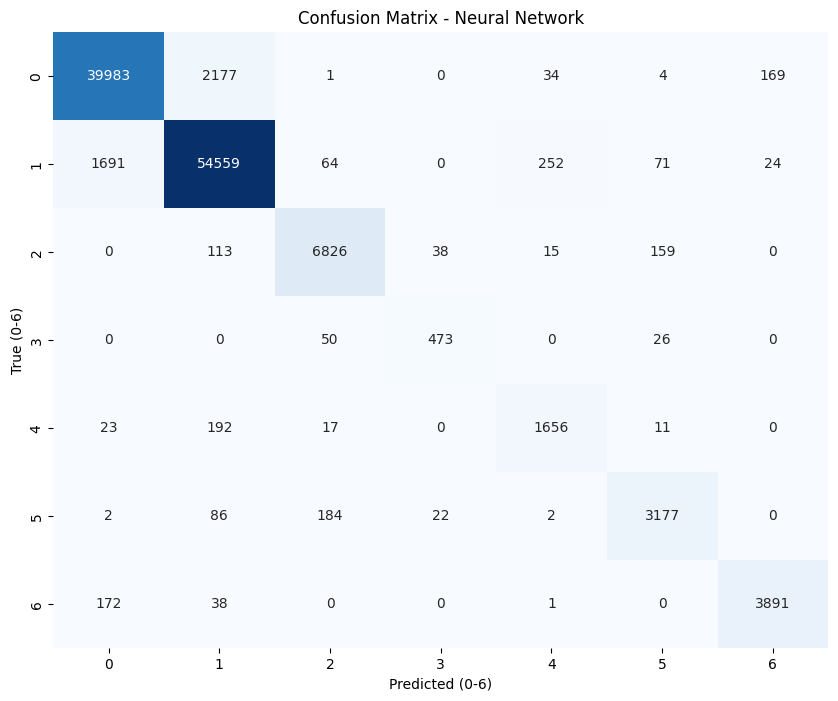

In [55]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted (0-6)')
plt.ylabel('True (0-6)')
plt.show()